In [20]:
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import medial_axis


from RANSAC import get_inliers, get_best_dist
from ImgCropper import ImgCropper

In [21]:
image = cv2.imread('images/nb7.jpg')
image.shape

(3504, 2480, 3)

In [22]:
%%time
cropped_img = ImgCropper().crop_image(image, hl_threshold=500, resize=True)

[[ 218.          143.5311831 ]
 [ 218.         2269.5311831 ]
 [1577.         2269.72513201]
 [1577.          143.72513201]]
CPU times: user 1.47 s, sys: 112 ms, total: 1.58 s
Wall time: 1.55 s


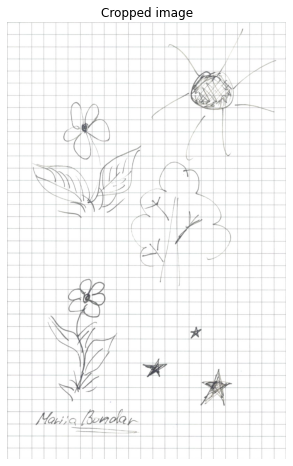

In [23]:
plt.figure(figsize=(5,10))
plt.axis("off")
plt.title("Cropped image")
plt.imshow(cropped_img)

In [24]:
# cv2.imwrite('./images/cropped.png', cropped_img)

find new lines and display them

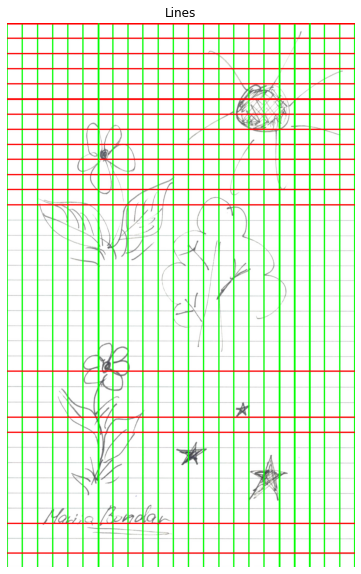

In [25]:
edges = ImgCropper.find_edges(cropped_img)
lines = cv2.HoughLines(edges, 1, np.pi/180, 600,)
img_copy = cropped_img.copy()
for i, line in enumerate(lines):
    for rho, theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 4000*(-b))
        y1 = int(y0 + 4000*(a))
        x2 = int(x0 - 4000*(-b))
        y2 = int(y0 - 4000*(a))
        if theta < 0.1:
            cv2.line(img_copy,(x1,y1),(x2,y2),(0,255,0),3)
        elif theta > 1.5:
            cv2.line(img_copy,(x1,y1),(x2,y2),(255,0,0),3)

plt.figure(figsize=(10,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy)

get approximated distance between lines

In [26]:
edges = ImgCropper.find_edges(cropped_img)
lines = cv2.HoughLines(edges, 1, np.pi/180, 600, )

rhos = lines[:, 0, 0]
thetas = lines[:, 0, 1]
vert_rhos = rhos[thetas < 0.1]
hors_rhos = rhos[thetas > 1.]

vert_dist, start1 = get_best_dist(vert_rhos, cropped_img.shape[1])
hors_dist, start2 = get_best_dist(hors_rhos, cropped_img.shape[0])

print(f'vert_dist {vert_dist}, start1 {start1}')
print(f'hors_dist {hors_dist}, start2 {start2}')

vert_dist 59, start1 1
hors_dist 59, start2 1


complete cells with not found lines

In [27]:
eps = 10
vert_lines = [(start1, 0)]
hors_lines =  [(start2, 1.5707)]

while start1 + vert_dist <= cropped_img.shape[1]:
    lines = vert_rhos[(vert_rhos > start1 + vert_dist - eps) & (vert_rhos < start1 + vert_dist + eps)]
    if len(lines):
        line = np.mean(lines)
    else:
        line = start1 + vert_dist
    vert_lines.append((line, 0))
    start1 = line
    
while start2 + vert_dist <= cropped_img.shape[0]:
    lines = hors_rhos[(hors_rhos > start2 + hors_dist - eps) & (hors_rhos < start2 + hors_dist + eps)]
    if len(lines):
        line = np.mean(lines)
    else:
        line = start2 + hors_dist
    hors_lines.append((line, 1.5707))
    start2 = line

display lines

(2126, 1359, 3)

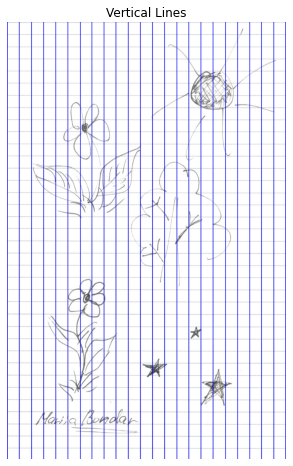

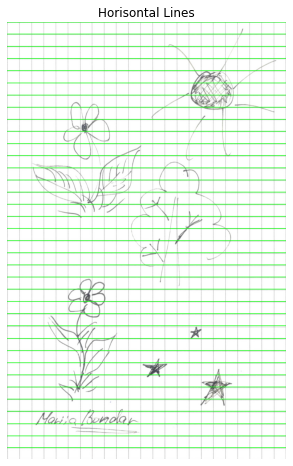

In [28]:
img_copy = cropped_img.copy()    
# img_copy = np.zeros(shape=cropped_img.shape)
for rho, theta in vert_lines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 4000*(-b))
    y1 = int(y0 + 4000*(a))
    x2 = int(x0 - 4000*(-b))
    y2 = int(y0 - 4000*(a))
    cv2.line(img_copy,(x1,y1),(x2,y2),(0, 0, 255),2)
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Vertical Lines")
plt.imshow(img_copy)
# cv2.imwrite('./images/cropped_vertical_mask.png', img_copy)

img_copy = cropped_img.copy()  
# img_copy = np.zeros(shape=cropped_img.shape)

for rho, theta in hors_lines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 5000*(-b))
    y1 = int(y0 + 5000*(a))
    x2 = int(x0 - 5000*(-b))
    y2 = int(y0 - 5000*(a))
    cv2.line(img_copy,(x1,y1),(x2,y2),(0,255,0),2)
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Horisontal Lines")
plt.imshow(img_copy)
# cv2.imwrite('./images/cropped_hor_lines.jpg', img_copy)
cv2.imwrite('./images/cropped_with_lines.png', img_copy)
# v - 23
# h - 35

img_copy.shape

resize an image to make square cells

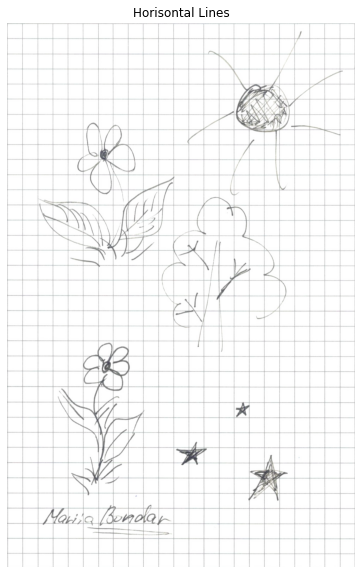

In [29]:
if vert_dist != hors_dist:
    ratio = hors_dist/vert_dist
    cropped_img = cv2.resize(cropped_img, dsize=(int(cropped_img.shape[1]*ratio), cropped_img.shape[0]), interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(10,10))
plt.clf()
plt.axis("off")
plt.title("Horisontal Lines")
plt.imshow(cropped_img)

In [52]:
skel, distance = medial_axis(bw, return_distance=True)

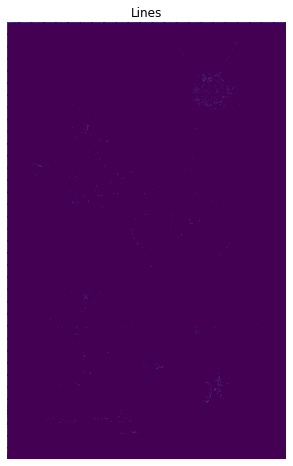

In [53]:
skeleton = distance * skel

plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(skeleton)

In [55]:
for rho, _ in vert_lines:
    for i in range(skeleton.shape[0]):
        skeleton[i, int(rho)-5:int(rho)+5]=[0]
        
for rho, _ in hors_lines:
    for j in range(skeleton.shape[1]):
        skeleton[int(rho)-5:int(rho)+5, j]=[0]
        

In [50]:
for i in range(cropped_img.shape[0]):
    for j in range(cropped_img.shape[1]):
        if dist3[i,j] == 0:
            cropped_img[i,j]=[255, 255, 255]